# ECE 535/435 Lab 4: MMSE Estimation and Least Squares

### Import Required Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from time import time
import matplotlib.patches as mpatches

# from google.colab import files
# uploaded = files.upload()

%matplotlib inline

In [50]:
# Functions for packing and unpacking images. 
# These are provided.

def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

### Load Data

For the training data, the first 1000 columns are the digit of 0, the next 1000 columns are the digit of 1, and so on, up to digit 9. For the testing data, the first 100 columns are the digit of 0, the next 100 columns are the digit of 1, and so on, up to digit 9.

In [51]:
# Load MNIST train and test data
# Normalize image pixels to [0,1]

train = np.load('MNISTcwtrain1000.npy').astype(float)/255
test = np.load('MNISTcwtest100.npy').astype(float)/255

size = train.shape[0]
n_train = train.shape[1]
n_test = test.shape[1]

print('-----MNIST Dataset Loaded-----')
print('Train Data: %d x %d' %(size,n_train))
print('Test Data: %d x %d' %(size,n_test))

-----MNIST Dataset Loaded-----
Train Data: 784 x 10000
Test Data: 784 x 1000


In [52]:
# This function will return the indices of the pixels in 
# a centered square of side length: d = 2, 4, 6, 8,..., 12, 14. 
# It is provided.

def return_mask_idx(sl):
    s = 14-sl//2   
    idx = []
    for i in range(sl):
        for j in range(sl):
            idx.append(28*(s+i)+s+j) 
    return idx

### 1. Mask Center Square of MNIST Digits
a) Implement a function to fill an dxd square in the image center with black.  
b) Using $d = 12$, display the original image and the corresponding masked image, in a 1 by 2 array, for the first example in each class of the testing data. 

c) Now use the training data to estimate the MMSE affine estimator $(W, b)$ of the masked pixel values based on the unmasked pixel values. Write this so that you can use any vlaue of $d$.  
d) Now modify you code for part b) to display the original image, the corresponding masked image, and the estimated image in a 1 by 3 array, for the first example in each class of the testing data. 

In [53]:
#This function is provided

def hide(img_vector, mask_idx):
    img_vector_copy = np.copy(img_vector)
    img_vector_copy[mask_idx] = 0
    return img_vector_copy

In [54]:
# Display original, masked, and estimated testing images 
# This code is given to you: 
# dd = 12
# hidden_idx = return_mask_idx(dd)
# remain_idx = np.delete(np.arange(0, 784), hidden_idx) 

# function that returns remaining pixels as X, masked pixels as Y,
# and indices of the remaining and masked pixels
def masked_matrices(dd, data):

  # get indices of the masked square and remove them from remaining indices
  hidden_idx = return_mask_idx(dd)
  remain_idx = np.delete(np.arange(0, 784), hidden_idx)
  

  # X has masked pixels removed from the given dataset
  X = np.ones((remain_idx.size, data.shape[1]))
  for i in range(remain_idx.size):
    X[i] = data[remain_idx[i]]

  # Y has all the masked pixels from the given dataset
  Y = np.ones((len(hidden_idx), data.shape[1]))
  for i in range(len(hidden_idx)):
    Y[i] = data[hidden_idx[i]]
  
  return X, Y, hidden_idx, remain_idx
#----------------------------------------------------------------
# Compute W and b using the training data
# delete the rows of training data corresponding to masked pixels


# takes remaining pixels from training and fit it to the masked pixels to find W*
def estimator_matrix(X, Y, hidden_idx, remain_idx):

  # calculate entire covariance matrix and 
  # extract the block matrices covar of X and covar of X, Y 
  cov = np.cov(X, Y)
  cov_X = cov[:remain_idx.size, :remain_idx.size]
  cov_XY = cov[:remain_idx.size, remain_idx.size:]

  # add 0.001 * identity to make singular
  cov_X_added = cov_X + (0.001 * np.identity(remain_idx.size))

  # calculate W = cov(X)^(-1) * cov(XY)
  W = np.linalg.inv(cov_X_added) @ cov_XY
  return W

# form min MSE affine estimator y^(x) = W*T(x - mu_x) + mu_y 
def form_estimator(W, X, Y):

  # find mean vector of features and target
  mu_x = np.mean(X, axis=1, keepdims = True)
  mu_y = np.mean(Y, axis=1, keepdims = True)

  # form estimator from formula
  estimator = W.T @ (X - mu_x) + mu_y

  # normalize estimator by setting negative values to 0
  # and > 1 values to 1 
  norm_0 = np.where(estimator < 0, 0, estimator)
  norm_1 = np.where(norm_0 > 1, 1, norm_0) 

  return norm_1

# mask the matrices for dd = 12 and form estimator of masked pixels on training data
X_train_1, Y_train_1, hidden_idx_1, remain_idx_1 = masked_matrices(12, train)
X_test_1, Y_test_1, *rest = masked_matrices(12, test)

W_1 = estimator_matrix(X_train_1, Y_train_1, hidden_idx_1, remain_idx_1)
estimator_1 = form_estimator(W_1, X_test_1, Y_test_1)

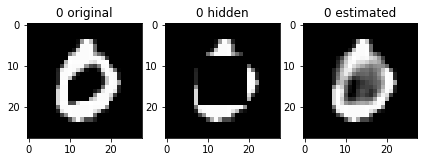

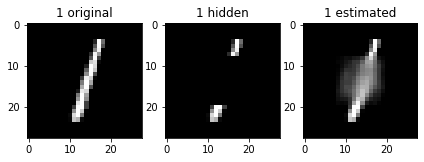

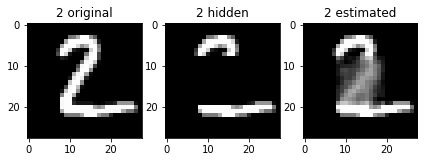

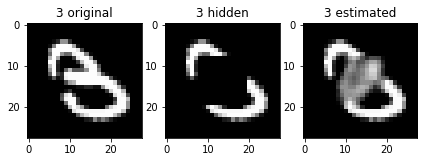

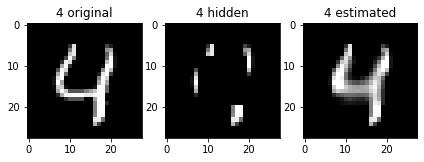

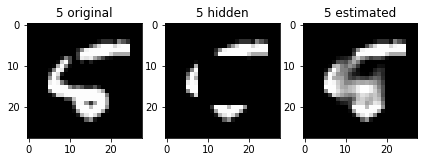

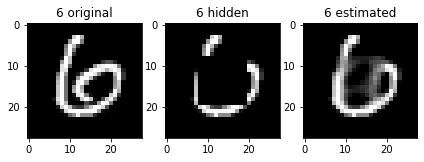

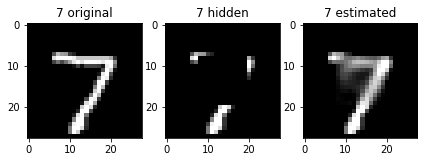

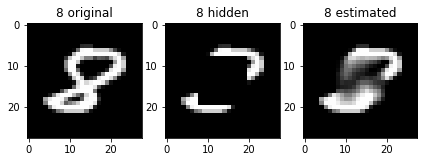

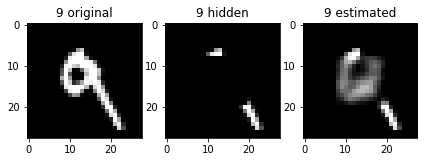

In [55]:
#----------------------------------------------------------------
# Loop over all classes 0,...,9

for i in range(10):  
  # Get the first test example in each class and plot
  sample = (test.T[i * (100)])

  plt.rcParams["figure.figsize"] = (7,7)
  plt.figure()
  plt.subplot(1,3,1)

  plt.title(str(i) + ' original')
  plt.imshow(unpackcw(sample, 28, 28), plt.cm.gray)

  # hide the center square and plot
  hidden = hide(test.T[i * (100)], hidden_idx_1)

  plt.subplot(1,3,2)
  plt.title(str(i) + ' hidden')
  plt.imshow(unpackcw(hidden, 28, 28), plt.cm.gray)

  # form copy of test data
  reconstruct_1 = np.copy(test.T[i * 100])
  counter = 0

  # for each hidden pixel in test data, replace that pixel with estimated[first example][counter]
  for missing in hidden_idx_1:
    reconstruct_1[missing] = estimator_1.T[i * 100][counter]
    counter += 1
  
  plt.subplot(1,3,3)
  plt.title(str(i) + ' estimated')
  plt.imshow(unpackcw(reconstruct_1, 28, 28), plt.cm.gray)

  plt.show()

### 2. Classify the Images using the nearest mean classifier.

The nearest mean classifier uses the image labels (0,...,9) to compute the mean image of each class ($\mu_0$, $\mu_1$, ...,$\mu_9$). Then classifies a new example to be the label of the nearest class mean.  
$$ \hat y (x) = \arg\min_{i\in [0,9]} \|x- \mu_i\|^2 $$  

(a) Compute the class means using the unmasked training images.   
(b) Classify the training images using the nearest mean classifer. Record the accuracy.  
(c) Classify the testing images using the nearest mean classifer. Record the accuracy. 

(d) For $d=2,..., 14$ classify the masked training images and the masked testing images using the nearest mean classifer.  
(e) Plot the classification error as a function of $d$. On the plot also indicate the classification error for the unmasked images and chance accuracy. Use a legend to distinguish the lines.

In [56]:
# Use the training data to compute the class means

def find_class_means(data):

  # 10 X number of pixels matrix
  class_means = np.ones((10, data.shape[0]))

  # form matrix of all the ith digit and compute mean
  for i in range(10):
    class_matrix = data.T[i * 1000: (i + 1) * 1000]
    class_mean = np.mean(class_matrix, axis=0, keepdims=True)
    class_means[i] = class_mean
  return class_means

# Define nearest mean classifier
def nearest_mean_classifier(x, class_means):
  norm_differences = []

  # calculate argmin_i ||x - class_mean[i]}}^2
  for i in range(10):
    norm_differences.append(np.square(np.linalg.norm(x - class_means[i])))
  return norm_differences.index(min(norm_differences))

def classify(data, class_means):
  counter = 0
  accuracy = 0

  # how many examples per number digit
  sizePerDigit = data.shape[1] // 10

  # find class means on the training set
  # class_means = find_class_means(training_set)
  
  # for each example, if classifier gives the right digit, increment accuracy
  for example in data.T:
    if (nearest_mean_classifier(example, class_means) == counter // sizePerDigit):
      accuracy += 1
    counter += 1
  
  return (accuracy / data.shape[1])

In [57]:
# First: Classify the training data
# find class means and classify
class_means_2 = find_class_means(train)

accuracy_train = classify(train, class_means_2)
print("Unmasked training classifier: " + str(accuracy_train))

# Second: classify the testing data
accuracy_test = classify(test, class_means_2)
print("Unmasked testing classifier: " + str(accuracy_test))

# Third: Classify the masked training data vs d

# arrays to track accuracy for each dd
accuracy_masked_train = []
accuracy_masked_test = []

for dd in np.linspace(2, 14, 7):

  # form dd-masked training data
  X_train_2, Y_train_2, *rest = masked_matrices(int(dd), train)

  # find class means for dd-masked training
  class_means_2_dd = find_class_means(X_train_2)

  # classify and add to list
  accuracy_masked_train.append(classify(X_train_2, class_means_2_dd))

  #repeat for testing data on training data class means
  X_test_2, Y_test_2, *rest = masked_matrices(int(dd), test)
  accuracy_masked_test.append(classify(X_test_2, class_means_2_dd))

print("Masked training classifier: " + str(accuracy_masked_train))

# Fourth: Classify the corrupted testing data vs d  
print("Masked testing classifier: " + str(accuracy_masked_test))

Unmasked training classifier: 0.8038
Unmasked testing classifier: 0.767
Masked training classifier: [0.8, 0.7841, 0.7595, 0.722, 0.6786, 0.6425, 0.6048]
Masked testing classifier: [0.765, 0.739, 0.709, 0.687, 0.65, 0.592, 0.547]


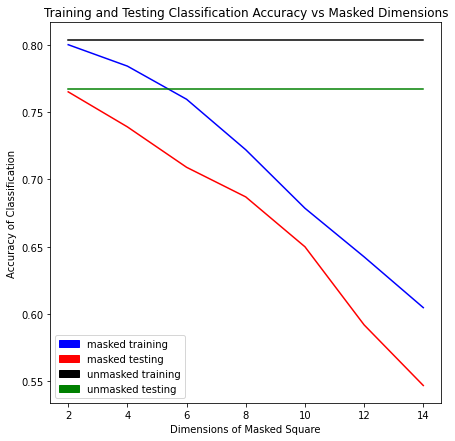

In [58]:
# plot accuracy of training and testing as dd increase
x = np.linspace(2, 14, 7)

plt.title("Training and Testing Classification Accuracy vs Masked Dimensions") 
plt.xlabel("Dimensions of Masked Square") 
plt.ylabel("Accuracy of Classification") 

plt.plot(x, accuracy_masked_train, color='blue')
plt.plot(x, accuracy_masked_test, color='red')
plt.plot(x, [accuracy_train] * 7 , color= "black")
plt.plot(x, [accuracy_test] * 7 , color= "green")

pop_a = mpatches.Patch(color='blue', label='masked training')
pop_b = mpatches.Patch(color='red', label='masked testing')
pop_c = mpatches.Patch(color='black', label='unmasked training')
pop_d = mpatches.Patch(color='green', label='unmasked testing')
plt.legend(handles=[pop_a,pop_b, pop_c, pop_d])

plt.show()

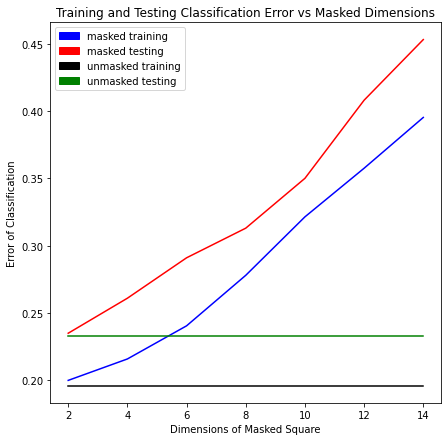

In [59]:
# plot error of training and testing as dd increase
x = np.linspace(2, 14, 7)

plt.title("Training and Testing Classification Error vs Masked Dimensions") 
plt.xlabel("Dimensions of Masked Square") 
plt.ylabel("Error of Classification") 

plt.plot(x, [1 - y for y in accuracy_masked_train], color='blue')
plt.plot(x, [1 - y for y in accuracy_masked_test], color='red')
plt.plot(x, [1 - accuracy_train] * 7 , color= "black")
plt.plot(x, [1 - accuracy_test] * 7 , color= "green")

pop_a = mpatches.Patch(color='blue', label='masked training')
pop_b = mpatches.Patch(color='red', label='masked testing')
pop_c = mpatches.Patch(color='black', label='unmasked training')
pop_d = mpatches.Patch(color='green', label='unmasked testing')
plt.legend(handles=[pop_a,pop_b, pop_c, pop_d])

plt.show()

### 3. Use least squares to approximate the masked pixels (estimation of the hidden part of the image)
Calculate the MSE for each example by constructing the following affine MSE estimator.

\begin{equation}
\arg \min_{W\in\mathbb{R}^{d^2 x(784-d^2)}}\|y-Wx-b\|_2^2
\end{equation}
\begin{equation}
y \in \mathbb{R}^{d^2}  \hspace{5mm} b \in \mathbb{R}^{d^2} \hspace{5mm} X \in \mathbb{R}^{(784-d^2)}
\end{equation}

Here $y$ is the vector of masked pixel valaues and $x$ is the remainder of the pixel values. 

Then use thr NM classifier to classify each reconstructed test image and each reconstructed traing image.
Plot the accuracies in each on a copy of the previous plot.

In [60]:
# Predict of missing pixels on testing data then classify
# Predict of missing pixels on training data then classify

accuracy_masked_train_predict = []
accuracy_masked_test_predict = []
MSE_training = []
MSE_testing = []

for dd in np.linspace(2, 14, 7):

  # form masked training and testing sets
  X_train_3, Y_train_3, hidden_idx_3, remain_idx_3 = masked_matrices(int(dd), train)
  X_test_3, Y_test_3, *rest = masked_matrices(int(dd), test)

  # form W* and create estimator for each dataset
  W = estimator_matrix(X_train_3, Y_train_3, hidden_idx_3, remain_idx_3)

  estimator_train_3 = form_estimator(W, X_train_3, Y_train_3)
  estimator_test_3 = form_estimator(W, X_test_3, Y_test_3)

  MSE_training.append(np.mean(np.square(Y_train_3 - estimator_train_3)))
  MSE_testing.append(np.mean(np.square(Y_test_3 - estimator_test_3)))

  # copy train and test data to reconstruct with estimated pixels
  reconstruct_train_3 = np.copy(train)
  reconstruct_test_3 = np.copy(test)
  
  # look index of missing pixels and replace with next value in estimation of masked pixels
  counter = 0
  for missing in hidden_idx_3:
    reconstruct_train_3[missing] = estimator_train_3[counter]
    reconstruct_test_3[missing] = estimator_test_3[counter]
    counter += 1

  # construct class means on reconstructed training set
  class_means_3_dd = find_class_means(reconstruct_train_3)

  accuracy_masked_train_predict.append(classify(reconstruct_train_3, class_means_3_dd))
  accuracy_masked_test_predict.append(classify(reconstruct_test_3, class_means_3_dd))

print("MSE training: " + str(MSE_training))
print("MSE testing: " + str(MSE_testing))
print("Masked predicted training classifier: " + str(accuracy_masked_train_predict))
print("Masked predicted testing classifier: " + str(accuracy_masked_test_predict))

MSE training: [0.02200186675791492, 0.04909558027640297, 0.06867542872191928, 0.07940559758634815, 0.08669291014428601, 0.09278026719932653, 0.09818190370684683]
MSE testing: [0.025280376359522093, 0.05818077905237377, 0.07978647615541574, 0.0890832592840527, 0.09659860558269949, 0.1031439060781185, 0.1086756612171297]
Masked predicted training classifier: [0.8022, 0.793, 0.7761, 0.7508, 0.7173, 0.6824, 0.6506]
Masked predicted testing classifier: [0.765, 0.759, 0.724, 0.707, 0.682, 0.644, 0.622]


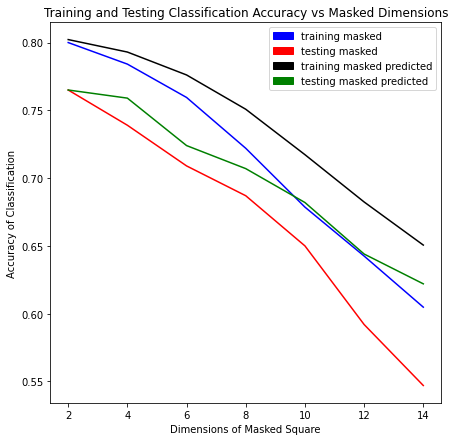

In [61]:
# Plot performance of all 
x = np.linspace(2, 14, 7)

plt.title("Training and Testing Classification Accuracy vs Masked Dimensions") 
plt.xlabel("Dimensions of Masked Square") 
plt.ylabel("Accuracy of Classification") 
plt.plot(x, accuracy_masked_train, color='blue')
plt.plot(x, accuracy_masked_test, color='red')
plt.plot(x, accuracy_masked_train_predict, color='black')
plt.plot(x, accuracy_masked_test_predict, color='green')
pop_a = mpatches.Patch(color='blue', label='training masked')
pop_b = mpatches.Patch(color='red', label='testing masked')
pop_c = mpatches.Patch(color='black', label='training masked predicted')
pop_d = mpatches.Patch(color='green', label='testing masked predicted')

plt.legend(handles=[pop_a,pop_b,pop_c,pop_d])

plt.show()